In [8]:
import pandas as pd

### Extracting proportions of export countries have made

In [9]:
# change these paths as necessary
VOLZA_PATH = '../../volza/magnesium/magnesium.csv'
SPOT_PRICES_PETROLEUM = "../../volza/petroleum/petrol_crude_oil_spot_price.csv"

volza = pd.read_csv(VOLZA_PATH)
volza = volza.dropna(subset=["Country of Origin"])
# filter out just the rows where the std. unit is in KG or TNE or TON
volza = volza[volza["Std. Unit"].isin(["KGS", "TNE", "TON"])]
spot_prices = pd.read_csv(SPOT_PRICES_PETROLEUM, sep=";")

In [10]:
volza['Year'] = pd.DatetimeIndex(volza['Date']).year
volza['Month'] = pd.DatetimeIndex(volza['Date']).month

In [11]:
import numpy as np

# defining some constants
proportions_of_sales_by_country_and_months = []
_country_keys = np.unique(volza["Country of Origin"])
months = list(range(1, 13))
years = list(range(2020, 2023))
conversion_factor = {
    "KGS": 1,
    "Kgs": 1,
    "TON": 907.185,
    "TNE": 1000
}

# calculating the proportions
for year in years:
    for month in months:
        volza_month_year = volza[(volza["Month"] == month) & (volza["Year"] == year)]
        curr_row = { country: 0 for country in _country_keys }
        _sum = 0
        for i in range(volza_month_year.shape[0]):
            country = volza.iloc[i]["Country of Origin"]
            quantity = volza.iloc[i]["Std. Quantity"]
            unit = volza.iloc[i]["Std. Unit"]
            curr_row[country] += quantity * conversion_factor[unit]
            _sum += quantity
        for country in _country_keys:
            curr_row[country] = round(curr_row[country] / _sum, 4)
        curr_row["Month"] = month
        curr_row["Year"] = year
        proportions_of_sales_by_country_and_months.append(curr_row)

### Monthly commodity price extraction

In [12]:
commodity_prices = pd.read_csv("../..//volza/magnesium/magnesium_price_2.csv")
commodity_prices['Year'] = pd.DatetimeIndex(commodity_prices['Date']).year
commodity_prices['Month'] = pd.DatetimeIndex(commodity_prices['Date']).month
commodity_prices["Price"] = pd.to_numeric(commodity_prices["Price"].str.replace(",", ""))

_idx = 0
for year in years:
    for month in months:
        monthly_prices = commodity_prices[(commodity_prices["Month"] == month) & (commodity_prices["Year"] == year)]
        proportions_of_sales_by_country_and_months[_idx]["median_commodity_price"] = np.median(monthly_prices["Price"])
        _idx += 1

### Extracting petroleum prices on a monthly basis

In [21]:
START_DATE = "2020-01-01"
END_DATE = "2022-12-31"
spot_prices_filtered = spot_prices[(spot_prices.Date >= START_DATE) & (spot_prices.Date <= END_DATE)]
spot_prices_filtered.head(2)

,Date,Spot Prices,Value,duoarea,area-name,product,product-name,process,process-name,series
3395,2020-01-01,Brent Spot Price (U.S. Dollars per Barrel),67.77,ZEU,NaN,EPCBRENT,UK Brent Crude Oil,PF4,Spot Price FOB,RBRTE
3396,2020-01-02,WTI Spot Price (U.S. Dollars per Barrel),61.17,YCUOK,NaN,EPCWTI,WTI Crude Oil,PF4,Spot Price FOB,RWTC


In [24]:
spot_prices_filtered['Year'] = pd.DatetimeIndex(spot_prices_filtered['Date']).year
spot_prices_filtered['Month'] = pd.DatetimeIndex(spot_prices_filtered['Date']).month

_idx = 0
for year in years:
    for month in months:
        monthly_prices = spot_prices_filtered[(spot_prices_filtered["Month"] == month) & (spot_prices_filtered["Year"] == year)]
        proportions_of_sales_by_country_and_months[_idx]["median_petroleum_price"] = np.median(monthly_prices["Value"])
        _idx += 1

C:\Users\manim\AppData\Local\Temp\ipykernel_97944\1984097924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_prices_filtered['Year'] = pd.DatetimeIndex(spot_prices_filtered['Date']).year
C:\Users\manim\AppData\Local\Temp\ipykernel_97944\1984097924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_prices_filtered['Month'] = pd.DatetimeIndex(spot_prices_filtered['Date']).month


### Checking for correlation

In [23]:
proportion_df = pd.DataFrame(proportions_of_sales_by_country_and_months)
proportion_df.drop(columns=["Year", "Month"], inplace=True)

proportion_df.head(2)

,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Colombia,Croatia,Cyprus,...,Taiwan,Tunisia,Turkey,United Kingdom,United States,Uzbekistan,Venezuela,Vietnam,median_commodity_price,median_petroleum_price
0,0.0960,0.1464,0.0,0.0,0.0,0.0,5.8140,0.0,0.2629,0.0,...,0.0628,0.0,0.5306,0.0456,0.0,0.0,0.0,0.0,14050.0,59.650
1,0.1063,0.1371,0.0,0.0,0.0,0.0,6.3037,0.0,0.2910,0.0,...,0.0695,0.0,0.5622,0.0505,0.0,0.0,0.0,0.0,14700.0,53.335


In [30]:
correlations = proportion_df.corr(method='kendall')
# correlations.to_csv("correlations.csv")
correlations.tail()

,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Colombia,Croatia,Cyprus,...,Taiwan,Tunisia,Turkey,United Kingdom,United States,Uzbekistan,Venezuela,Vietnam,median_commodity_price,median_petroleum_price
Uzbekistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Venezuela,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Vietnam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
median_commodity_price,0.190256,0.233704,NaN,0.607794,NaN,NaN,-0.126301,NaN,0.017758,NaN,...,-0.657496,NaN,-0.177577,-0.675788,0.529369,NaN,NaN,NaN,1.000000,0.668785
median_petroleum_price,0.290074,0.360746,NaN,0.624725,NaN,NaN,0.003195,NaN,0.064525,NaN,...,-0.661989,NaN,-0.275108,-0.719099,0.655200,NaN,NaN,NaN,0.668785,1.000000


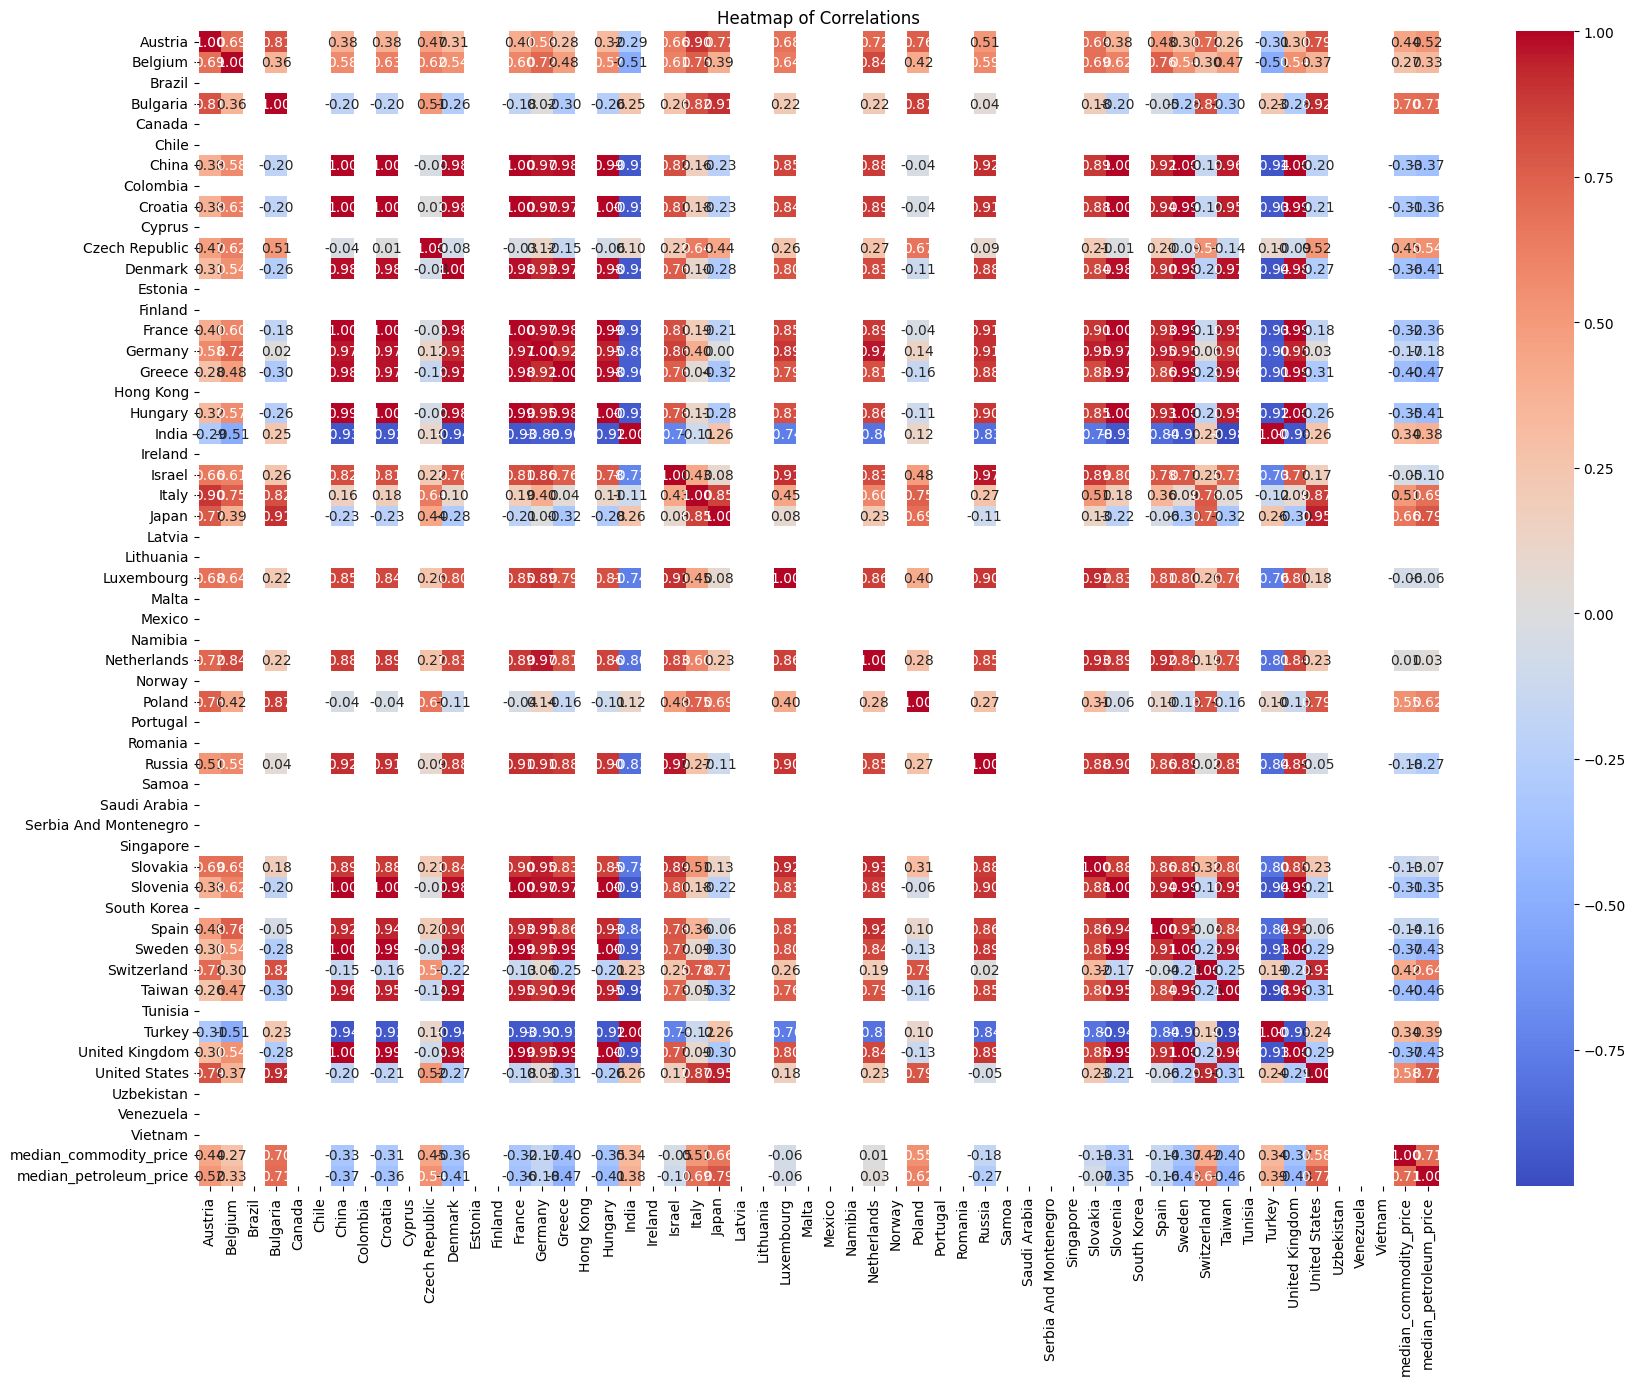

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the correlation data, skipping the first unnamed column
correlation_data = pd.read_csv('correlations.csv', index_col=0)

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))  # Adjust the size as needed

# Draw the heatmap
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap='coolwarm', square=False)

# Add titles and labels for clarity
plt.title('Heatmap of Correlations')
plt.xticks(rotation=90)  
plt.yticks(rotation=0)  

# Show the plot
plt.show()